In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [ ]:
import numpy as np
import pandas as pd
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Embedding, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, AveragePooling2D, MaxPooling2D, MaxPool1D, ZeroPadding1D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers.merge import concatenate
from sklearn.metrics import classification_report

In [ ]:
mit_test_data = pd.read_csv('mitbih_test.csv', header=None)
mit_test_data = mit_test_data.sample(frac=1).reset_index(drop=True)

mit_train_data = pd.read_csv('mitbih_train.csv', header=None)
mit_train_data = mit_train_data.sample(frac=1).reset_index(drop=True)

ptbdb_abnormal_data = pd.read_csv('ptbdb_abnormal.csv', header=None)
ptbdb_normal_data = pd.read_csv('ptbdb_normal.csv', header=None)
ptb_both_data = [ptbdb_abnormal_data, ptbdb_normal_data]
ptb_all_data = pd.concat(ptb_both_data,keys=["abnormal","normal"])
random_boolean_array = np.random.rand(len(ptb_all_data)) < 0.8

train_ptb = ptb_all_data[random_boolean_array]
test_ptb = ptb_all_data[~random_boolean_array]

In [ ]:
from keras.utils import to_categorical
mit_train_X, mit_train_y = mit_train_data.iloc[: , :-1], mit_train_data.iloc[: , -1]
mit_train_X, mit_val_X, mit_train_y, mit_val_y= train_test_split(mit_train_X,mit_train_y,test_size=0.2)
mit_test_X, mit_test_y = mit_test_data.iloc[: , :-1], mit_test_data.iloc[: , -1]
mit_train_y = to_categorical(mit_train_y)
mit_test_y = to_categorical(mit_test_y)
mit_val_y=to_categorical(mit_val_y)


ptb_train_X = train_ptb.loc[:, train_ptb.columns != 187]
ptb_train_y = train_ptb.loc[:, train_ptb.columns == 187]
ptb_train_y = to_categorical(ptb_train_y)
ptb_test_X = test_ptb.loc[:, test_ptb.columns != 187]
ptb_test_y = test_ptb.loc[:, test_ptb.columns == 187]
ptb_test_y = to_categorical(ptb_test_y)

In [ ]:
print('N: ',len(mit_train_y[mit_train_y[:,0] == 1]))
print('S: ',len(mit_train_y[mit_train_y[:,1] == 1]))
print('V: ',len(mit_train_y[mit_train_y[:,2] == 1]))
print('F: ',len(mit_train_y[mit_train_y[:,3] == 1]))
print('Q: ',len(mit_train_y[mit_train_y[:,4] == 1]))


N:  57935
S:  1796
V:  4662
F:  512
Q:  5138


In [ ]:
print('Normal: ',len(ptb_train_y[ptb_train_y[:,0] == 1]))
print('Abormal: ',len(ptb_train_y[ptb_train_y[:,1] == 1]))

Normal:  3264
Abormal:  8464


In [ ]:
print("mit_train_X shape:" , str(mit_train_X.shape))
print("mit_train_y shape:" , str(mit_train_y.shape))
print("mit_val_X shape:" , str(mit_val_X.shape))
print("mit_val_y shape:" , str(mit_val_y.shape))
print("mit_test_X shape:" , str(mit_test_X.shape))
print("mit_test_y shape:" , str(mit_test_y.shape))

print("ptb_train_X shape: ", str(ptb_train_X.shape) )
print("ptb_train_y shape:", str(ptb_train_y.shape) )
print("ptb_test_X shape", str(ptb_test_X.shape) )
print("ptb_test_y shape", str(ptb_test_y.shape) )

mit_train_X shape: (70043, 187)
mit_train_y shape: (70043, 5)
mit_val_X shape: (17511, 187)
mit_val_y shape: (17511, 5)
mit_test_X shape: (21892, 187)
mit_test_y shape: (21892, 5)
ptb_train_X shape:  (11728, 187)
ptb_train_y shape: (11728, 2)
ptb_test_X shape (2824, 187)
ptb_test_y shape (2824, 2)


In [ ]:
def residual_block(X, f, filters):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv1D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)

    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

def create_resnet_model(num_classes, input_shape = (187,1), ):

    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)

    X = Conv1D(64, 7, activation='relu', strides = 2)(X)
    X = BatchNormalization()(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = residual_block(X, 3, [128,128,512])
    X = residual_block(X, 3, [128,128,512])
    X = residual_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = Flatten()(X)
    X = Dense(num_classes,activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet')

    return model

Training and prediction using using MIT dataset

In [ ]:
resNet_model_mit = create_resnet_model(5, input_shape = (187,1))

In [ ]:
resNet_model_mit.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 193, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 94, 64)       512         zero_padding1d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 94, 64)       256         conv1d[0][0]                     
_____________________________________________________________________________________________

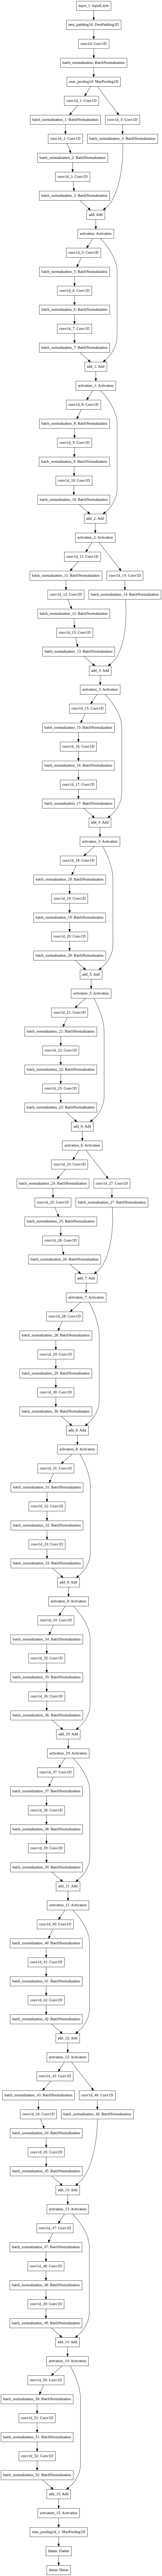

In [ ]:
plot_model(resNet_model_mit)

In [ ]:
resNet_model_mit.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resNet_model_history_mit = resNet_model_mit.fit(mit_train_X, mit_train_y, epochs = 20, batch_size = 100, validation_data = (mit_val_X, mit_val_y))

Epoch 1/20
701/701 [==============================] - 118s 105ms/step - loss: 0.7199 - accuracy: 0.8833 - val_loss: 0.3645 - val_accuracy: 0.9407
Epoch 2/20
701/701 [==============================] - 71s 101ms/step - loss: 0.1562 - accuracy: 0.9646 - val_loss: 0.3924 - val_accuracy: 0.9653
Epoch 3/20
701/701 [==============================] - 72s 102ms/step - loss: 0.2316 - accuracy: 0.9618 - val_loss: 0.1565 - val_accuracy: 0.9681
Epoch 4/20
701/701 [==============================] - 72s 102ms/step - loss: 0.2294 - accuracy: 0.9614 - val_loss: 0.1177 - val_accuracy: 0.9652
Epoch 5/20
701/701 [==============================] - 72s 103ms/step - loss: 0.2452 - accuracy: 0.9651 - val_loss: 0.4047 - val_accuracy: 0.9127
Epoch 6/20
701/701 [==============================] - 72s 103ms/step - loss: 0.2939 - accuracy: 0.9512 - val_loss: 0.4370 - val_accuracy: 0.9083
Epoch 7/20
701/701 [==============================] - 72s 103ms/step - loss: 0.1230 - accuracy: 0.9683 - val_loss: 0.0973 - val_a

Text(0, 0.5, 'Accuracy')

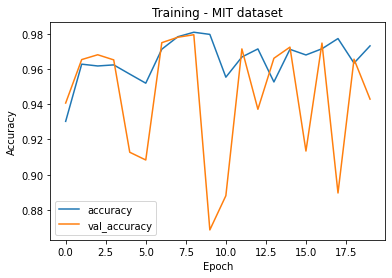

In [ ]:
plt.plot(resNet_model_history_mit.history['accuracy'])
plt.plot(resNet_model_history_mit.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.title('Training - MIT dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
mit_pred_y = resNet_model_mit.predict(mit_test_X) # make prediction here
mit_predictions = []
for x in mit_pred_y:
  #print(x)
  most_conf_index = np.argmax(x)
  mit_predictions.append(most_conf_index)

mit_actual = []
for x in mit_test_y:
  #print(x)
  most_conf_index = np.argmax(x)
  mit_actual.append(most_conf_index)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(mit_actual, mit_predictions))

0.943129910469578


[[18055    15    36     0    12]
 [  272   269    15     0     0]
 [  417     6   937     0    88]
 [  154     0     8     0     0]
 [  165     2    55     0  1386]]


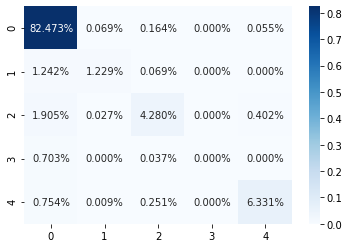

In [ ]:
mit_cf_matrix = confusion_matrix(mit_actual, mit_predictions)
print(mit_cf_matrix)
sns.heatmap(mit_cf_matrix/np.sum(mit_cf_matrix), annot=True,fmt='.3%', cmap='Blues')

In [ ]:
print(classification_report(mit_actual,mit_predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     18118
           1       0.92      0.48      0.63       556
           2       0.89      0.65      0.75      1448
           3       0.00      0.00      0.00       162
           4       0.93      0.86      0.90      1608

    accuracy                           0.94     21892
   macro avg       0.74      0.60      0.65     21892
weighted avg       0.93      0.94      0.94     21892



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training and prediction using ptb dataset

In [ ]:
resNet_model_ptb = create_resnet_model(2, input_shape = (187,1))

In [ ]:
resNet_model_ptb.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 193, 1)       0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_53 (Conv1D)              (None, 94, 64)       512         zero_padding1d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 94, 64)       256         conv1d_53[0][0]                  
_____________________________________________________________________________________________

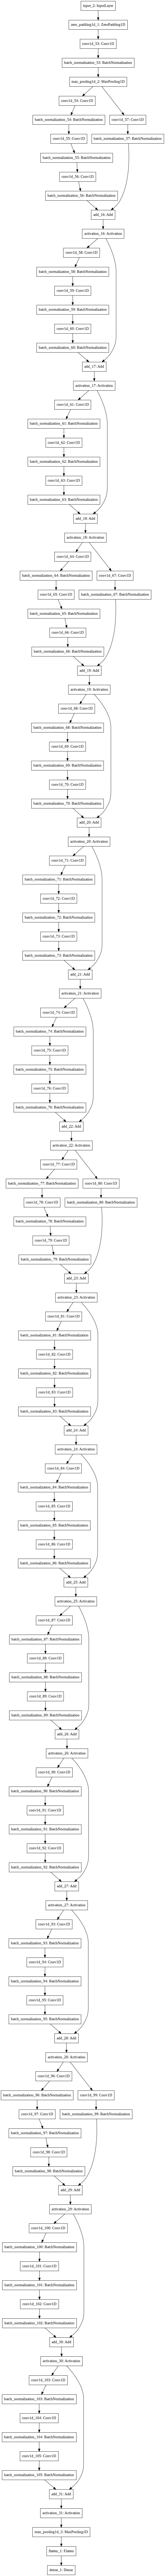

In [ ]:
plot_model(resNet_model_ptb)

In [ ]:
resNet_model_ptb.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resNet_model_history_ptb = resNet_model_ptb.fit(ptb_train_X, ptb_train_y, epochs = 20, batch_size = 100, validation_split=0.2)

Epoch 1/20
94/94 [==============================] - 24s 138ms/step - loss: 1.7383 - accuracy: 0.8384 - val_loss: 4.7058 - val_accuracy: 0.0000e+00
Epoch 2/20
94/94 [==============================] - 10s 102ms/step - loss: 0.3038 - accuracy: 0.9156 - val_loss: 6.0627 - val_accuracy: 0.0000e+00
Epoch 3/20
94/94 [==============================] - 10s 103ms/step - loss: 0.1541 - accuracy: 0.9507 - val_loss: 7.0566 - val_accuracy: 0.0000e+00
Epoch 4/20
94/94 [==============================] - 10s 103ms/step - loss: 0.0753 - accuracy: 0.9736 - val_loss: 9.1095 - val_accuracy: 4.2626e-04
Epoch 5/20
94/94 [==============================] - 10s 102ms/step - loss: 0.0757 - accuracy: 0.9750 - val_loss: 10.4028 - val_accuracy: 8.5251e-04
Epoch 6/20
94/94 [==============================] - 10s 102ms/step - loss: 0.0639 - accuracy: 0.9794 - val_loss: 5.2259 - val_accuracy: 0.0575
Epoch 7/20
94/94 [==============================] - 10s 102ms/step - loss: 0.0312 - accuracy: 0.9890 - val_loss: 5.5824 -

Text(0, 0.5, 'Accuracy')

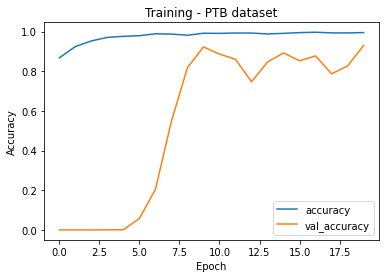

In [ ]:
plt.plot(resNet_model_history_ptb.history['accuracy'])
plt.plot(resNet_model_history_ptb.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.title('Training - PTB dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


In [ ]:
ptb_pred_y = resNet_model_ptb.predict(ptb_test_X) # make prediction here
ptb_predictions = []
for x in ptb_pred_y:
  #print(x)
  most_conf_index = np.argmax(x)
  ptb_predictions.append(most_conf_index)

ptb_actual = []
for x in ptb_test_y:
  #print(x)
  most_conf_index = np.argmax(x)
  ptb_actual.append(most_conf_index)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(ptb_actual, ptb_predictions))

0.9702549575070821


[[ 723   59]
 [  25 2017]]


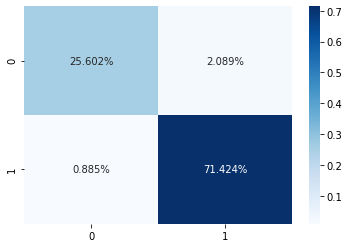

In [ ]:
ptb_cf_matrix = confusion_matrix(ptb_actual, ptb_predictions)
print(ptb_cf_matrix)
sns.heatmap(ptb_cf_matrix/np.sum(ptb_cf_matrix), annot=True,fmt='.3%', cmap='Blues')

In [ ]:
print(classification_report(ptb_actual,ptb_predictions))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       782
           1       0.97      0.99      0.98      2042

    accuracy                           0.97      2824
   macro avg       0.97      0.96      0.96      2824
weighted avg       0.97      0.97      0.97      2824

